# Model Selection - Example

## Example Model
Measurement data are simulation results with the "true" model. The comprehensive model includes additional behaviour involving a third parameter. Hence, during model selection, models with $\theta_3=0$ should be preferred.

![](model_selection_network.jpeg)


# Model Space Specifications File

The model selection specification file can be written in the following compressed format.

| model_id | petab_yaml                             | $\theta_1$ | $\theta_2$ | $\theta_3$ |
|:---------|:----------------------------------|:----|:----|:----|
| M1      | example_modelSelection.yaml | 0;estimate  | 0;estimate  | 0;estimate  |

Alternatively, models can be explicitly specified. The below table is equivalent to the above table.

| model_id | petab_yaml                             | $\theta_1$ | $\theta_2$ | $\theta_3$ |
|:---------|:----------------------------------|:----|:----|:----|
| M1_0	| example_modelSelection.yaml	| 0	  | 0   |	0 | 
| M1_1	| example_modelSelection.yaml	| 0	  | 0	| estimate |
| M1_2	| example_modelSelection.yaml	| 0	  | estimate |	0 |
| M1_3	| example_modelSelection.yaml	| estimate |	0	| 0 |
| M1_4	| example_modelSelection.yaml	| 0	  | estimate |	estimate |
| M1_5	| example_modelSelection.yaml	| estimate |	0   |	estimate |
| M1_6	| example_modelSelection.yaml	| estimate |	estimate |	0 |
| M1_7	| example_modelSelection.yaml	| estimate | estimate |	estimate |

Either of the above tables (as [.tsv](https://en.wikipedia.org/wiki/Tab-separated_values) files) are valid inputs. Any combinations of cells in the compressed or explicit format is also acceptable, including the following example.

| model_id | petab_yaml                             | $\theta_1$ | $\theta_2$ | $\theta_3$ |
|:---------|:----------------------------------|:----|:----|:----|
| M1      | example_modelSelection.yaml | 0;estimate  | 0;estimate  | 0  |
| M2      | example_modelSelection.yaml | 0;estimate  | 0;estimate  | estimate  |

Internally, estimated parameters (`estimate`) are represented by `float('nan')`.

Due to the topology of the example model, setting $\theta_1$ to zero can result in a model with no dynamics. Hence, for this example, some parameters are set to non-zero fixed values. These parameters are not considered as estimated values in criterion (e.g. AIC) calculations.

The model specification table used in this notebook is copied below.

| model_id | petab_yaml                  | k1       | k2       | k3       |
|----------|-----------------------------|----------|----------|----------|
| M1_0     | example_modelSelection.yaml | 0        | 0        | 0        |
| M1_1     | example_modelSelection.yaml | 0.2      | 0.1      | estimate |
| M1_2     | example_modelSelection.yaml | 0.2      | estimate | 0        |
| M1_3     | example_modelSelection.yaml | estimate | 0.1      | 0        |
| M1_4     | example_modelSelection.yaml | 0.2      | estimate | estimate |
| M1_5     | example_modelSelection.yaml | estimate | 0.1      | estimate |
| M1_6     | example_modelSelection.yaml | estimate | estimate | 0        |
| M1_7     | example_modelSelection.yaml | estimate | estimate | estimate |

In [1]:
import pypesto.select
import petab_select
from petab_select import Criterion, Method, FORWARD, BACKWARD, ESTIMATE
petab_select_problem = petab_select.Problem.from_yaml('model_selection/petab_select_problem.yaml')

# Forward Selection, Multiple Searches
Here, we show a typical workflow for model selection. First, a [PEtab](https://github.com/petab-dev/petab) problem is created. This is used to initialise a `ModelSelector`, along with a model specifications file.

In [2]:
#import pypesto.model_selection
import logging
import pypesto.logging
pypesto.logging.log(level=logging.INFO, name='pypesto.model_selection', console=True)
import petab

#petab_problem = petab.Problem.from_yaml(petab_YAML)
selector = pypesto.select.ModelSelector(problem=petab_select_problem)

Models can be selected with a model selection algorithm ([forward](https://en.wikipedia.org/wiki/Stepwise_regression)) and a comparison criterion ([AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)).

In [3]:
# Reduce notebook runtime 
minimize_options = {
    'n_starts': 1,
}

selected_models, _, selection_history = selector.select(
    Method.FORWARD,
    Criterion.AIC,
    minimize_options=minimize_options,
)
# Usually, only one model will be the best after selection iteration.
assert len(selected_models) == 1
selected_model_1 = selected_models[0]

----------------------New Selection---------------------
Using existing amici model in folder /home/dilan/Documents/future_annex/model_selection/packages/pyPESTO/doc/example/amici_models/caroModel_linear.
  0%|          | 0/1 [00:00<?, ?it/s]Executing task 0.
Final fval=17.4876, time=0.1695s, n_fval=29.
100%|██████████| 1/1 [00:00<00:00,  5.83it/s]
Starting with model: 649bcd92d8da15883a6709f3233e277e173aa6ce7ff1eda3f32d342a0f3a0e63ddd6e3764eab0c730dfb96440bab731ee67d412295a48e1e9949b3cc10935f28

Old ID	New ID	Crit	Old	New	Diff	Result


To search more of the model space, the algorithm can be repeated. As models with 1 or less estimated parameters have already been tested, subsequent `select` calls will begin with the next simplest model (in this case, models with exactly 2 estimated parameters), and move on to more complex models, while each iteration improves the criterion and additional valid models are available for testing.

In [4]:
selected_models, local_selection_history, selection_history = selector.select(
    Method.FORWARD,
    Criterion.AIC,                                                                         
    minimize_options=minimize_options,
    initial_model=selected_models[0],
)
assert len(selected_models) == 1
selected_model_2 = selected_models[0]

----------------------New Selection---------------------
Using existing amici model in folder /home/dilan/Documents/future_annex/model_selection/packages/pyPESTO/doc/example/amici_models/caroModel_linear.
  0%|          | 0/1 [00:00<?, ?it/s]Executing task 0.
Final fval=-4.0877, time=0.0782s, n_fval=16.
100%|██████████| 1/1 [00:00<00:00, 12.63it/s]
649bcd92d8da15883a6709f3233e277e173aa6ce7ff1eda3f32d342a0f3a0e63ddd6e3764eab0c730dfb96440bab731ee67d412295a48e1e9949b3cc10935f28	9202aceb387014e83f48a27e577758cd84f682df40dc52b5e79c99b150a27cc997276b7584be893fc59723e1eaa10dff9ba2bc0da53404996fa886aefdc08812	Criterion.AIC	36.975	-4.175	-41.151	Accepted
Using existing amici model in folder /home/dilan/Documents/future_annex/model_selection/packages/pyPESTO/doc/example/amici_models/caroModel_linear.
  0%|          | 0/1 [00:00<?, ?it/s]Executing task 0.
Final fval=-4.1373, time=0.6857s, n_fval=129.
100%|██████████| 1/1 [00:00<00:00,  1.45it/s]
649bcd92d8da15883a6709f3233e277e173aa6ce7ff1eda3f32

Plotting routines are available, to visualise the best model at each iteration of the selection process.

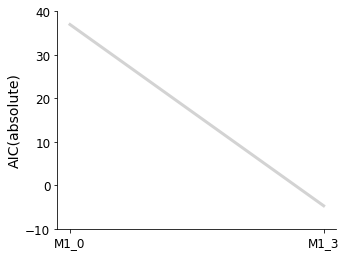

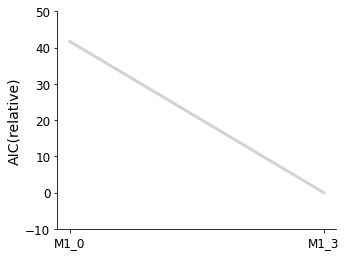

In [5]:
import pypesto.visualize.select as ms_vis
ax = ms_vis.plot_selected_models(
    [selected_model_1, selected_model_2],
    criterion=Criterion.AIC,
    relative=False,
    label_attribute='model_subspace_id',
)
ax = ms_vis.plot_selected_models(
    [selected_model_1, selected_model_2],
    criterion=Criterion.AIC,
    label_attribute='model_subspace_id',
)
ax.plot();

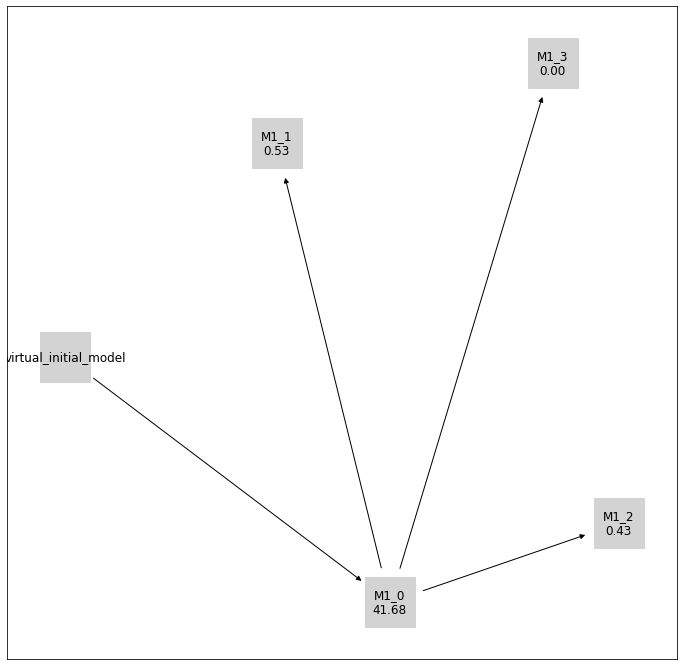

In [6]:
ms_vis.plot_history_digraph(selection_history, label_attribute='model_subspace_id')

# Backward Selection, Custom Initial Model
Backward selection is specified by changing the algorithm from `'forward'` to `'backward'`in the `ModelSelector.select()` call.

A custom initial model is specified with the optional `initial_model` argument of `ModelSelector.select()`. If no initial model is specified, then a virtual model is used for the purpose of finding the next valid models. For example, in forward selection, the initial virtual model with all parameters set to zero is used to find the next models to be tested. For backward selection, the initial virtual model has all parameters set to be estimated.

In [7]:
from pprint import pprint
import numpy as np
from petab_select import Model

petab_select_problem.model_space.reset_exclusions()
selector2 = pypesto.select.ModelSelector(problem=petab_select_problem)

petab_yaml = 'model_selection/example_modelSelection.yaml'
initial_model = Model(
    model_id='myModel',
    petab_yaml=petab_yaml,
    parameters=dict(
        k1=0.1,
        k2=ESTIMATE,
        k3=ESTIMATE,
    ),
    criteria={petab_select_problem.criterion: np.inf}
)

print('Initial model:')
print(initial_model)

Initial model:
model_id	petab_yaml	k1	k2	k3
myModel	model_selection/example_modelSelection.yaml	0.1	estimate	estimate


In [8]:
selected_models, local_selection_history, selection_history = selector2.select(
    Method.BACKWARD,
    Criterion.AIC,
    initial_model=initial_model,    
    minimize_options=minimize_options,
)

----------------------New Selection---------------------
Using existing amici model in folder /home/dilan/Documents/future_annex/model_selection/packages/pyPESTO/doc/example/amici_models/caroModel_linear.
  0%|          | 0/1 [00:00<?, ?it/s]Executing task 0.
Final fval=17.4875, time=0.1058s, n_fval=14.
100%|██████████| 1/1 [00:00<00:00,  9.33it/s]
myModel	9202aceb387014e83f48a27e577758cd84f682df40dc52b5e79c99b150a27cc997276b7584be893fc59723e1eaa10dff9ba2bc0da53404996fa886aefdc08812	Criterion.AIC	inf	38.975	-inf	Accepted
Using existing amici model in folder /home/dilan/Documents/future_annex/model_selection/packages/pyPESTO/doc/example/amici_models/caroModel_linear.
  0%|          | 0/1 [00:00<?, ?it/s]Executing task 0.
Final fval=10.0599, time=0.2085s, n_fval=35.
100%|██████████| 1/1 [00:00<00:00,  4.75it/s]
myModel	c77336267040331cfda996cb87b318896972a65038354bf1da57e5286b952ef2ab85621ad993cfc577453ad8196fc7be5aedf04f71fcf9514285afedf46cb1eb	Criterion.AIC	inf	24.120	-inf	Accepted


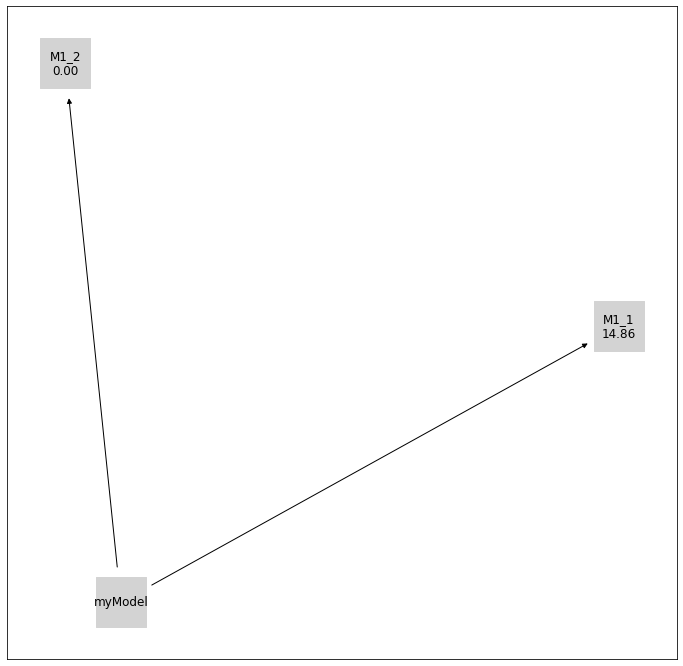

In [9]:
ms_vis.plot_history_digraph(selection_history, label_attribute='model_subspace_id')

# Additional Options
There exist additional options that can be used to further customise selection algorithms.
## Select First Improvement
At each selection step, as soon as a model that improves on the previous model is encountered (by the specified criterion), it is selected and immediately used as the previous model in the next iteration of the selection. This is unlike the default behaviour, where all test models at each iteration are optimized, and the best of these is selected.
## Use Previous Maximum Likelihood Estimate as Startpoint
The maximum likelihood estimate parameters from the previous model is used as one of the startpoints in the multistart optimization of the test models. The default behaviour is that all startpoints are automatically generated by pyPESTO.
## Minimize Options
Optimization can be customised with a dictionary that specifies values for the corresponding keyword arguments of [minimize](https://github.com/ICB-DCM/pyPESTO/blob/master/pypesto/optimize/optimize.py).
## Criterion Options
Currently implemented options are
- [`'AIC'`](https://en.wikipedia.org/wiki/Akaike_information_criterion) (Akaike information criterion),
- [`'AICc'`](https://en.wikipedia.org/wiki/Akaike_information_criterion) (corrected AIC), and
- [`'BIC'`](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (Bayesian information criterion).

### Threshold
A threshold can be specified, such that only models that improve on previous models by the threshold amount in the chosen criterion are accepted.

In [10]:
petab_select_problem.model_space.reset_exclusions()
selector3 = pypesto.select.ModelSelector(problem=petab_select_problem)
history_of_best_models = selector3.select_to_completion(
    Method.FORWARD,
    Criterion.BIC,
    select_first_improvement=True,
    startpoint_latest_mle=True,    
    minimize_options=minimize_options,
)

----------------------New Selection---------------------
Using existing amici model in folder /home/dilan/Documents/future_annex/model_selection/packages/pyPESTO/doc/example/amici_models/caroModel_linear.
  0%|          | 0/1 [00:00<?, ?it/s]Executing task 0.
Final fval=17.4876, time=0.1408s, n_fval=32.
100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
Starting with model: 649bcd92d8da15883a6709f3233e277e173aa6ce7ff1eda3f32d342a0f3a0e63ddd6e3764eab0c730dfb96440bab731ee67d412295a48e1e9949b3cc10935f28

Old ID	New ID	Crit	Old	New	Diff	Result
----------------------New Selection---------------------
Using existing amici model in folder /home/dilan/Documents/future_annex/model_selection/packages/pyPESTO/doc/example/amici_models/caroModel_linear.
  0%|          | 0/1 [00:00<?, ?it/s]Executing task 0.
Final fval=-4.0877, time=0.0824s, n_fval=16.
100%|██████████| 1/1 [00:00<00:00, 12.01it/s]
649bcd92d8da15883a6709f3233e277e173aa6ce7ff1eda3f32d342a0f3a0e63ddd6e3764eab0c730dfb96440bab731ee67d412295a4

<AxesSubplot:ylabel='BIC(relative)'>

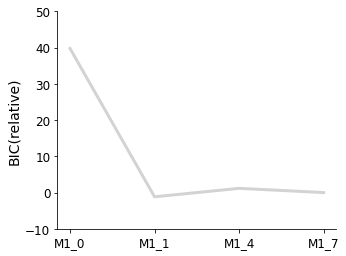

In [11]:
ms_vis.plot_selected_models(
    history_of_best_models,
    criterion=Criterion.BIC,
    label_attribute='model_subspace_id',
)

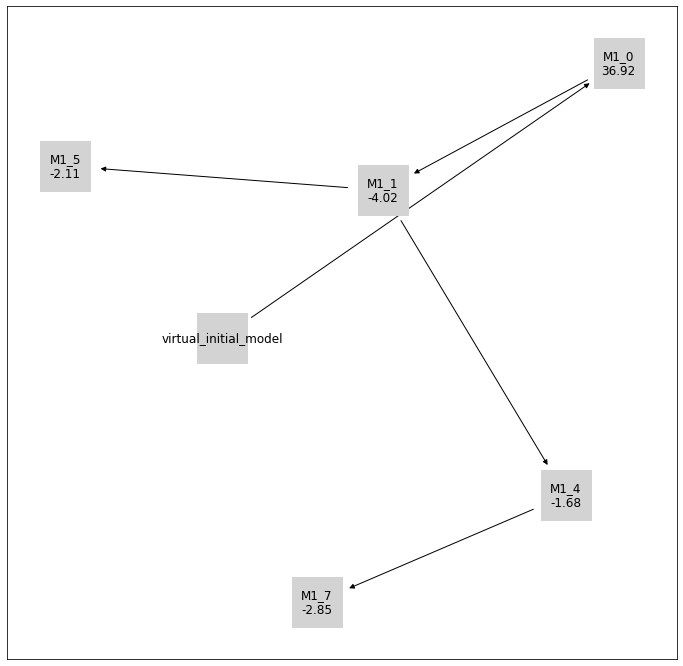

In [12]:
ms_vis.plot_history_digraph(
    selector3.selection_history,
    criterion=Criterion.BIC,
    relative=False,
    label_attribute='model_subspace_id',
)

In [13]:
# Repeat with AICc and criterion_threshold == 10
petab_select_problem.model_space.reset_exclusions()
selector4 = pypesto.select.ModelSelector(problem=petab_select_problem)
history_of_best_models = selector4.select_to_completion(
    Method.FORWARD,
    Criterion.AICC,
    select_first_improvement=True,
    startpoint_latest_mle=True,
    minimize_options=minimize_options,    
    criterion_threshold=10,
)

----------------------New Selection---------------------
Using existing amici model in folder /home/dilan/Documents/future_annex/model_selection/packages/pyPESTO/doc/example/amici_models/caroModel_linear.
  0%|          | 0/1 [00:00<?, ?it/s]Executing task 0.
Final fval=17.4876, time=0.0912s, n_fval=18.
100%|██████████| 1/1 [00:00<00:00, 10.84it/s]
Starting with model: 649bcd92d8da15883a6709f3233e277e173aa6ce7ff1eda3f32d342a0f3a0e63ddd6e3764eab0c730dfb96440bab731ee67d412295a48e1e9949b3cc10935f28

Old ID	New ID	Crit	Old	New	Diff	Result
----------------------New Selection---------------------
Using existing amici model in folder /home/dilan/Documents/future_annex/model_selection/packages/pyPESTO/doc/example/amici_models/caroModel_linear.
  0%|          | 0/1 [00:00<?, ?it/s]Executing task 0.
Final fval=-4.0877, time=0.1078s, n_fval=16.
100%|██████████| 1/1 [00:00<00:00,  9.15it/s]
649bcd92d8da15883a6709f3233e277e173aa6ce7ff1eda3f32d342a0f3a0e63ddd6e3764eab0c730dfb96440bab731ee67d412295a4

<AxesSubplot:ylabel='AICc(relative)'>

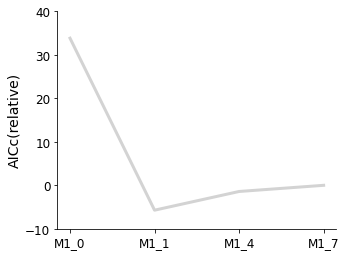

In [14]:
ms_vis.plot_selected_models(
    history_of_best_models,
    criterion=Criterion.AICC,
    label_attribute='model_subspace_id',
)

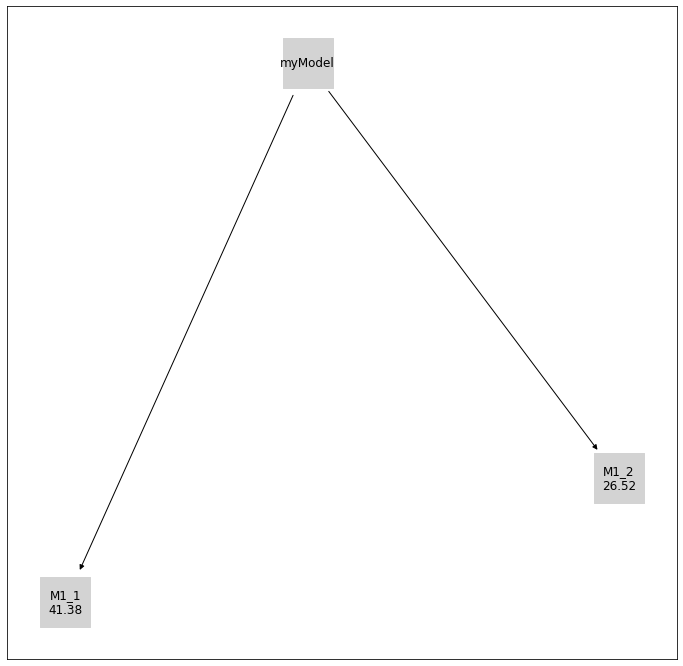

In [15]:
ms_vis.plot_history_digraph(
    selection_history,
    criterion=Criterion.AICC,
    relative=False,
    label_attribute='model_subspace_id',
)

# Multistart
Multiple model selections can be run by specifying initial models to be tested.

In [16]:
#selector5 = ms.ModelSelector(petab_problem, model_spec_file)
#model_space.reset()
petab_select_problem.model_space.reset_exclusions()
selector5 = pypesto.select.ModelSelector(problem=petab_select_problem)

initial_model1 = Model(
    model_id='myModel1',
    petab_yaml=petab_yaml,
    parameters=dict(
        k1=0,
        k2=0,
        k3=0,
    ),
    criteria={petab_select_problem.criterion: np.inf},
)

initial_model2 = Model(
    model_id='myModel2',
    petab_yaml=petab_yaml,
    parameters=dict(
        k1=ESTIMATE,
        k2=ESTIMATE,
        k3=0,
    ),
    criteria={petab_select_problem.criterion: np.inf},
)

initial_models = [initial_model1, initial_model2]
selected_models, local_selection_history, selection_history = selector5.multistart_select(
    Method.FORWARD,
    Criterion.AIC,
    initial_models=initial_models,
    minimize_options=minimize_options
)

----------------------New Selection---------------------
Using existing amici model in folder /home/dilan/Documents/future_annex/model_selection/packages/pyPESTO/doc/example/amici_models/caroModel_linear.
  0%|          | 0/1 [00:00<?, ?it/s]Executing task 0.
Final fval=17.4875, time=0.1720s, n_fval=27.
100%|██████████| 1/1 [00:00<00:00,  5.77it/s]
myModel1	9202aceb387014e83f48a27e577758cd84f682df40dc52b5e79c99b150a27cc997276b7584be893fc59723e1eaa10dff9ba2bc0da53404996fa886aefdc08812	Criterion.AIC	inf	38.975	-inf	Accepted
Using existing amici model in folder /home/dilan/Documents/future_annex/model_selection/packages/pyPESTO/doc/example/amici_models/caroModel_linear.
  0%|          | 0/1 [00:00<?, ?it/s]Executing task 0.
Final fval=10.0603, time=0.2250s, n_fval=29.
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
myModel1	c77336267040331cfda996cb87b318896972a65038354bf1da57e5286b952ef2ab85621ad993cfc577453ad8196fc7be5aedf04f71fcf9514285afedf46cb1eb	Criterion.AIC	inf	24.121	-inf	Accepted
U

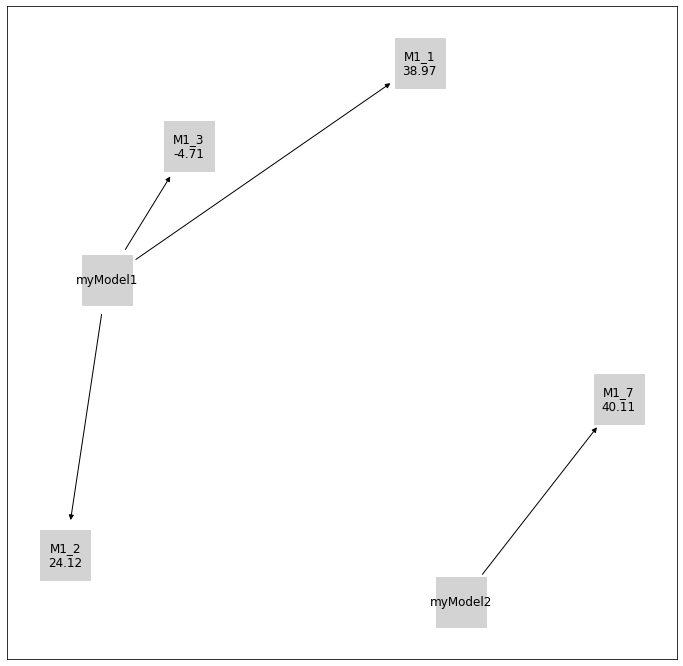

In [17]:
ms_vis.plot_history_digraph(
    selection_history,
    criterion=Criterion.AIC,
    relative=False,
    label_attribute='model_subspace_id',
)